# Cleaning the annoying trips in raw data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
url = "C:/Users/chloe/Downloads/full_dataset.csv"
df = pd.read_csv(url)
df['stop_headsign'].unique()

In [ ]:
#exclusion des bus stops passant par l'arrêt bizarre
list_trip_id = []
def do_you_stop(u) :
  if u['stop_name']=='Södersjukhuset':
    list_trip_id.append(u['trip_id'])
  elif u['stop_headsign'] in ['Sickla udde via Södersjukhuset','Hornsberg via Södersjukhuset']:
    list_trip_id.append(u['trip_id'])
  return None

df.apply(do_you_stop, axis=1)
list_trip_id = list(set(list_trip_id))

In [ ]:
df_annoying = df.loc[(df['trip_id'].isin(list_trip_id))
        & (~df['stop_name'].isin(['Södersjukhuset','Roselund','Södra station'])) 
        #& (df['stop_headsign'].isin(['Sickla udde via Södersjukhuset','Hornsberg via Södersjukhuset'])))
                    ]

def annoying_trips(u):
    if u['stop_headsign'] in ['Sickla udde via Södersjukhuset']:
        return 'Sickla udde'
    if u['stop_headsign'] in ['Hornsberg via Södersjukhuset']:
        return 'Hornsberg'
    else:
        return u['stop_headsign']
    
def annoying_sequences(u):
    if u['stop_headsign'] not in ['Sickla udde via Södersjukhuset','Hornsberg via Södersjukhuset']: 
        #if it isn't in the headsign, they already passed it
        u['stop_sequence_sched']-=1 
    return u['stop_sequence_sched']

df_annoying['stop_sequence_sched'] = df_annoying.apply(annoying_sequences, axis=1)

df_annoying['stop_headsign'] = df_annoying.apply(annoying_trips, axis=1)

In [ ]:
df_clean = pd.concat([df_annoying,df[~df['trip_id'].isin(list_trip_id)]])
#getting rid of the outliers : the whole trip when there is a problem on one stop

outi = []
def outlier_cleaning(u):
    if np.abs(u['arrival_delay_minutes'])>15:
        if u['stop_sequence_sched'] > 1:
            outi.append(u['trip_id'])
    return None
df_clean.apply(outlier_cleaning, axis=1)
outi= list(set(outi))
df_clean = df_clean[~df_clean['trip_id'].isin(outi)]


## Export

In [ ]:
df_clean.to_csv('data_propres.csv')

# Main code

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
url = "C:/Users/chloe/Downloads/data_propres.csv"
df = pd.read_csv(url)

## Adding missing indicators

In [2]:
df['arrival_delay_minutes'].describe()
df['arrival_delay_minutes'] = df['arrival_delay']/60

In [3]:
df = df.sort_values(by=['start_date','trip_id', 'stop_sequence_real'])
df['delays_evolution_minutes'] = df.groupby(['start_date','trip_id'])['arrival_delay'].diff().fillna(0)/60 
df['delays_evolution_minutes'].describe()

count    64529.000000
mean         0.004113
std          1.341257
min        -14.816667
25%         -0.416667
50%          0.000000
75%          0.400000
max        111.516667
Name: delays_evolution_minutes, dtype: float64

In [4]:
from datetime import datetime

df['departure_time_real'] = pd.to_datetime(df['departure_time_real'])
df['arrival_time_real'] = pd.to_datetime(df['arrival_time_real'])

df['dwell_time'] = df['departure_time_real']-df['arrival_time_real']
df['dwell_time_secs'] =df['dwell_time'].dt.total_seconds()
df['dwell_time'].describe()

count                        64497
mean     0 days 00:00:25.312851760
std      0 days 00:00:54.187837326
min                0 days 00:00:00
25%                0 days 00:00:08
50%                0 days 00:00:14
75%                0 days 00:00:25
max                0 days 01:50:56
Name: dwell_time, dtype: object

In [5]:
def peak_hour(u):
    hour = u.hour
    if 7 <= hour < 9 or 15 <= hour < 18:
        return 1
    return 0

df['peak_hour'] = df['departure_time_real'].apply(peak_hour)

## Grouping per lines and adding ROW %

In [6]:
performances_per_lines = {}
df_merged = []

for line in df['route_short_name'].unique():
    for dest in df['stop_headsign'].unique():
        subset = df.loc[(df['route_short_name'] == line) & (df['stop_headsign'] == dest)].copy()

        if subset.empty:
            continue
        print(line)
        print(dest)
        key = str(line) + '_' + dest
        subset = subset.loc[~(subset['stop_sequence_sched'] == 1)] # we exclude the departure stop from the delay analyse
        performances_per_lines[key] = subset
        
        path = "C:/Users/chloe/Downloads/row_percentage_segment_line" + key + ".csv"
        ROW = pd.read_csv(path, sep =';')
        subset = pd.merge(subset, ROW, left_on='stop_sequence_sched', right_on='stop_prout',how='left')

        df_merged.append(subset)
df_merged = pd.concat(df_merged, ignore_index=True)

53
Henriksdalsberget
53
Karolinska institutet
61
Ruddammen
61
Hornsberg
74
Hornsberg
74
Sickla udde


In [7]:
df_merged['verify'] = (df_merged['route_short_name_x'] == df_merged['route_short_name_y'])*(df_merged['stop_headsign'] == df_merged['destination'])
df_merged.loc[(df_merged['verify']==False)]

,Unnamed: 0,trip_id,start_date,schedule_relationship,stop_sequence_real_x,stop_id,arrival_time_real,arrival_delay,departure_time_real,departure_delay,...,destination,stop_sequence_real_y,stop_lat_y,stop_lon_y,percentage,stop_prout,median_speed,median_speed_79peak,stop_lon_1,verify


In [8]:
df_merged=df_merged[['trip_id', 'start_date',
       'stop_sequence_real_x', 'stop_id', 'arrival_time_real', 'arrival_delay',
       'departure_time_real', 'departure_delay', 'route_short_name_x',
       'arrival_time_sched', 'departure_time_sched',
       'stop_sequence_sched', 'stop_headsign',
       'shape_dist_traveled', 'stop_name',
       'arrival_delay_minutes', 'dwell_time', 'delays_evolution_minutes',
       'dwell_time_secs', 'peak_hour','route_short_name_y', 'destination',
       'stop_sequence_real_y', 'percentage',
       'stop_prout']]

## Correlations

In [56]:
df_merged.corr(numeric_only=True)['delays_evolution_minutes']

trip_id                    -0.001888
start_date                 -0.000368
stop_sequence_real_x       -0.359002
stop_id                     0.068993
arrival_delay               0.246725
departure_delay             0.222605
route_short_name_x         -0.038815
stop_sequence_sched        -0.357740
shape_dist_traveled        -0.368282
arrival_delay_minutes       0.246725
delays_evolution_minutes    1.000000
dwell_time_secs            -0.139443
route_short_name_y         -0.038815
stop_sequence_real_y       -0.357740
percentage                 -0.058078
stop_prout                 -0.357740
Name: delays_evolution_minutes, dtype: float64

In [57]:
df_merged.corr(numeric_only=True)['arrival_delay_minutes']

trip_id                    -0.003075
start_date                  0.041123
stop_sequence_real_x        0.008837
stop_id                    -0.008588
arrival_delay               1.000000
departure_delay             0.981773
route_short_name_x         -0.232553
stop_sequence_sched         0.012190
shape_dist_traveled         0.033038
arrival_delay_minutes       1.000000
delays_evolution_minutes    0.246725
dwell_time_secs            -0.151515
route_short_name_y         -0.232553
stop_sequence_real_y        0.012190
percentage                 -0.019847
stop_prout                  0.012190
Name: arrival_delay_minutes, dtype: float64

In [58]:
df_merged.corr(numeric_only=True)['percentage']

trip_id                     0.001971
start_date                  0.001339
stop_sequence_real_x       -0.085785
stop_id                     0.066767
arrival_delay              -0.019847
departure_delay            -0.002253
route_short_name_x          0.204615
stop_sequence_sched        -0.090116
shape_dist_traveled         0.003909
arrival_delay_minutes      -0.019847
delays_evolution_minutes   -0.058078
dwell_time_secs             0.092632
route_short_name_y          0.204615
stop_sequence_real_y       -0.090116
percentage                  1.000000
stop_prout                 -0.090116
Name: percentage, dtype: float64

## Plots

### Boxplots

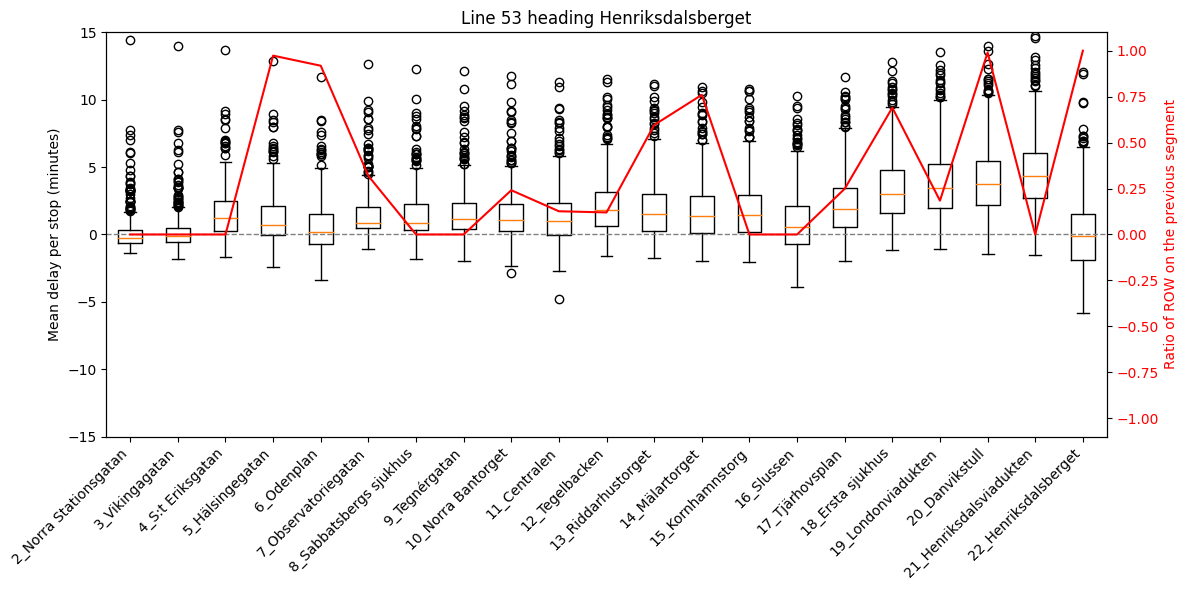

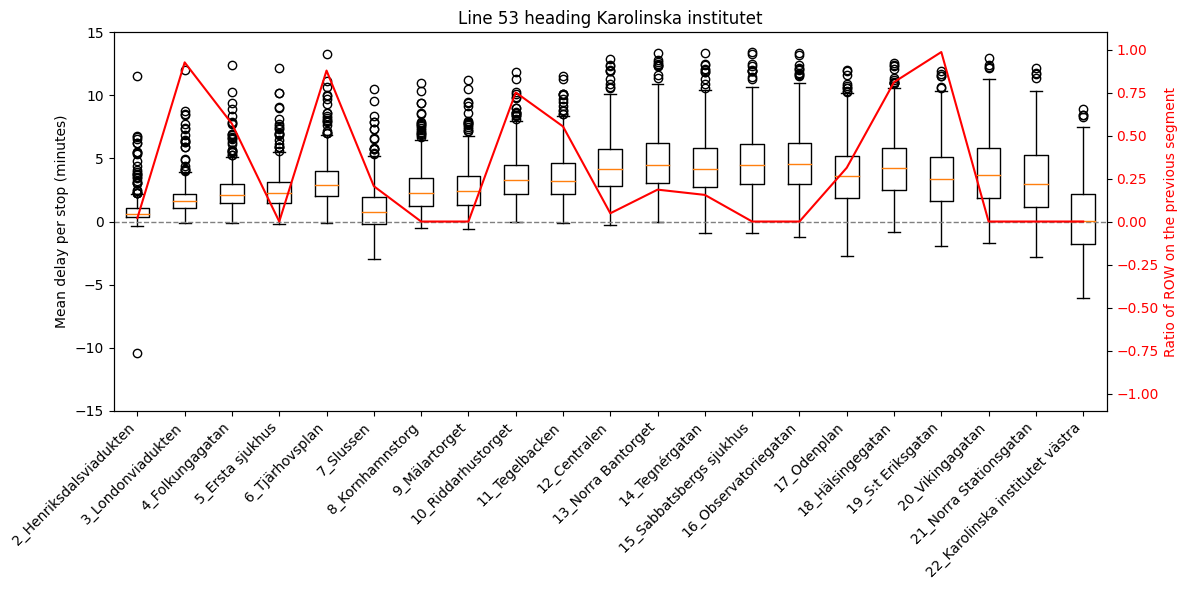

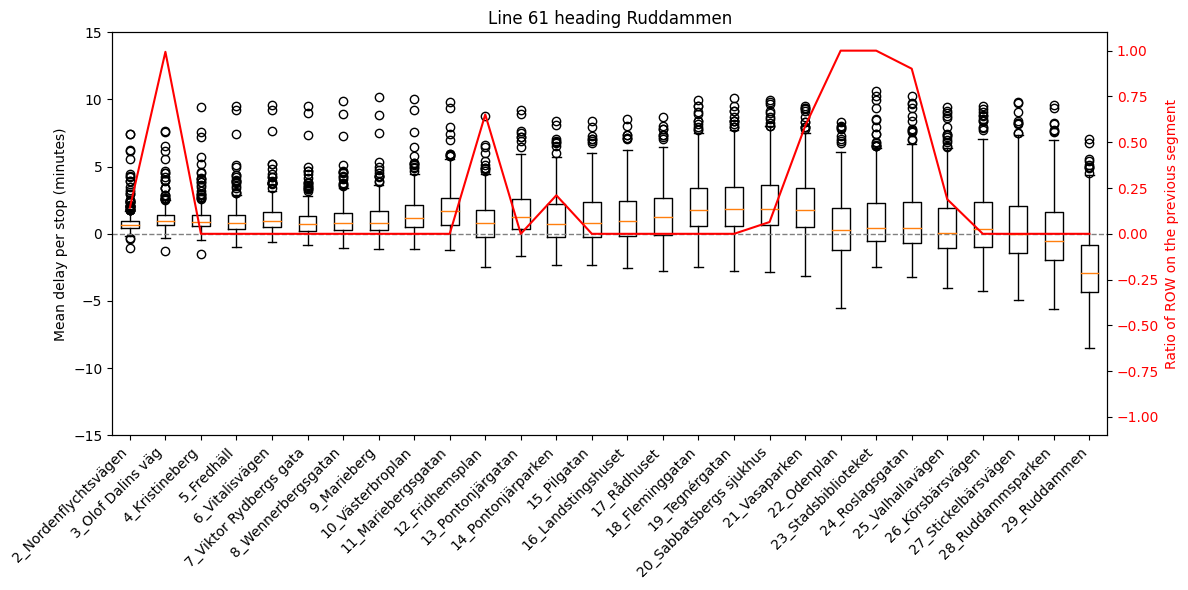

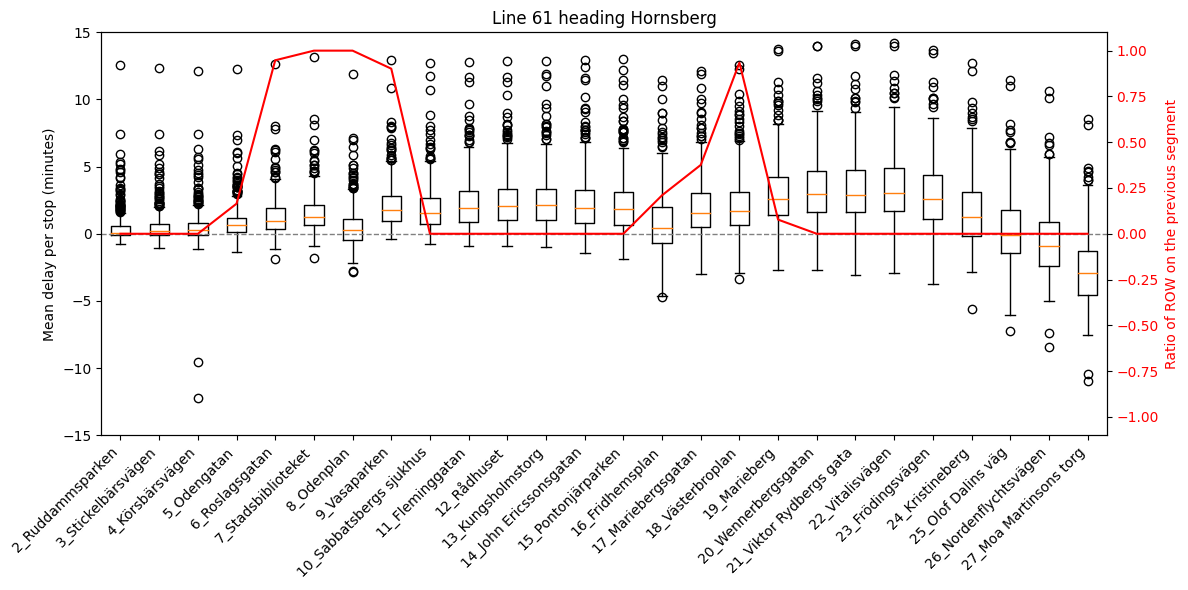

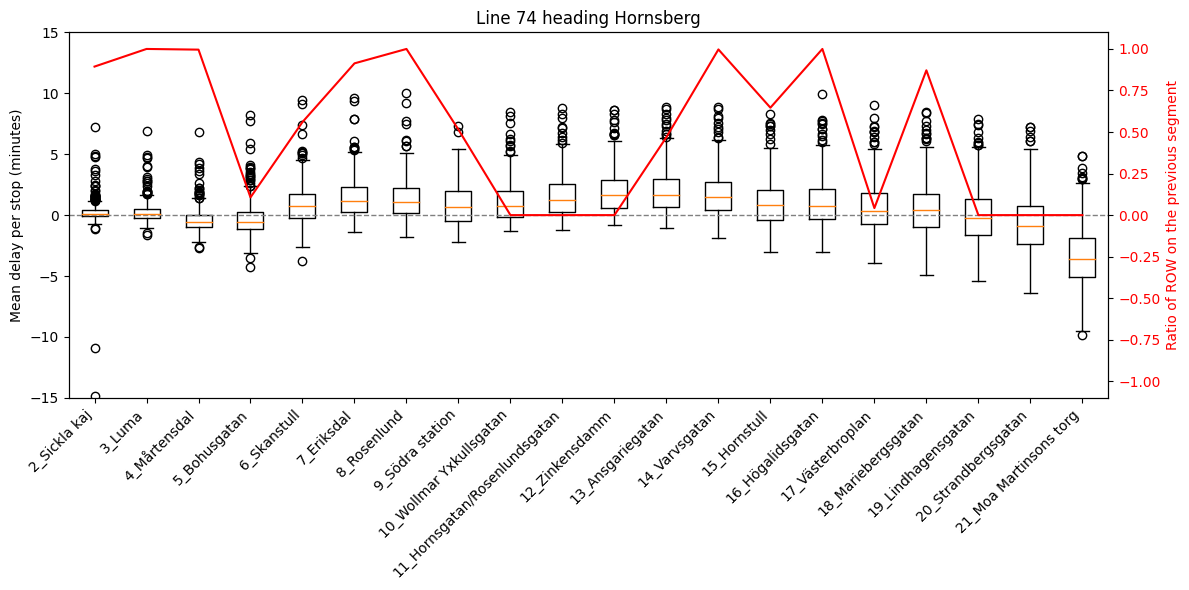

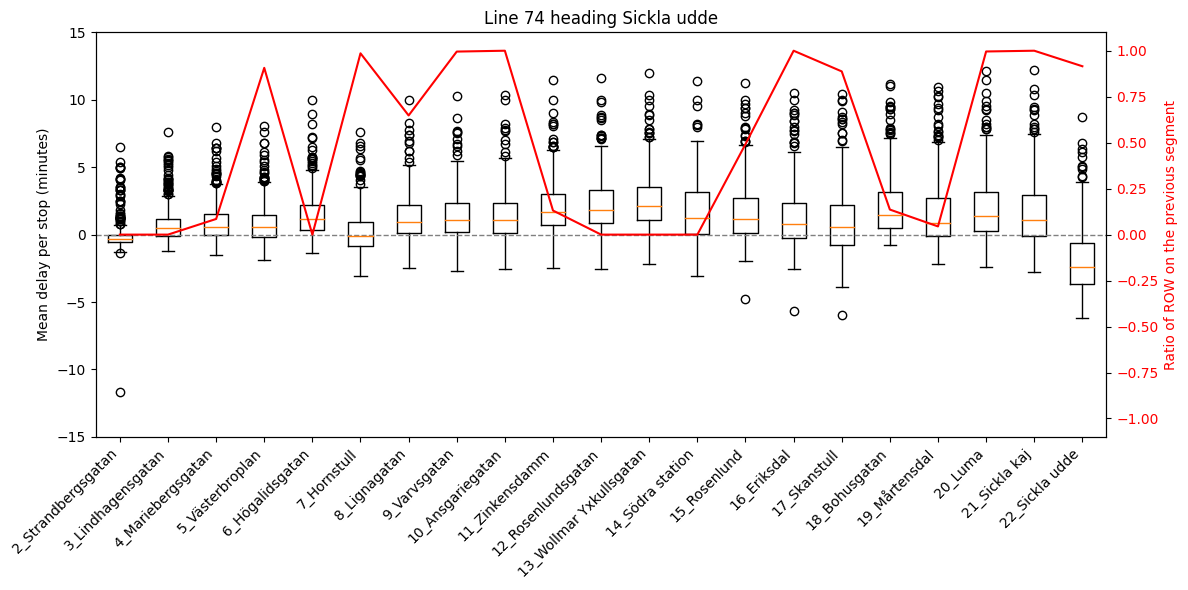

In [61]:
import matplotlib.pyplot as plt
def trace(key):

    subset = performances_per_lines[key]
    path = "C:/Users/chloe/Downloads/row_percentage_segment_line" + key + ".csv"
    line = subset['route_short_name'].unique()[0]
    dest = subset['stop_headsign'].unique()[0]
    ROW = pd.read_csv(path, sep=';')

    d = []        # To hold the delay values for each stop
    labels = []   # To hold x-axis labels
    for stop in sorted(subset['stop_sequence_sched'].unique()):
        stop_subset = subset.loc[subset['stop_sequence_sched'] == stop]
        #data = stop_subset['dwell_time'].dt.total_seconds() / 60
        data = stop_subset['arrival_delay_minutes']
        #data = stop_subset['delays_evolution_minutes']
        values = data.dropna().values


        stop_name = stop_subset['stop_name'].iloc[0]
        d.append(values)
        labels.append(f"{stop}_{stop_name}")

    # Plotting
    if d:
        fig, ax1 = plt.subplots(figsize=(12, 6))
        
        bp = ax1.boxplot(d)
        ax1.set_ylim(-15,15)
        ax1.set_xticklabels(labels, rotation=45, ha='right')
        ax1.axhline(y=0, color='gray', linestyle='--', linewidth=1)

        ax1.set_ylabel("Mean delay per stop (minutes)")
        ax1.set_title(f"Line {line} heading {dest}")

        # Création du second axe Y (partage le même axe X)
        ax2 = ax1.twinx()

        # Tracé de la deuxième courbe (pourcentages)
        ax2.set_ylim(-1.1,1.1)
        ax2.plot(ROW['stop_sequence_real'], ROW['percentage'], color='red', label='Percentages')#, linestyle=(0, (3,5,1,5)))
        ax2.set_ylabel('Ratio of ROW on the previous segment', color='red')
        ax2.tick_params(axis='y', labelcolor='red')

        plt.tight_layout()
        plt.show()      
               
    plt.show()
    
for key in performances_per_lines.keys():
    trace(key)

### Scatterplots

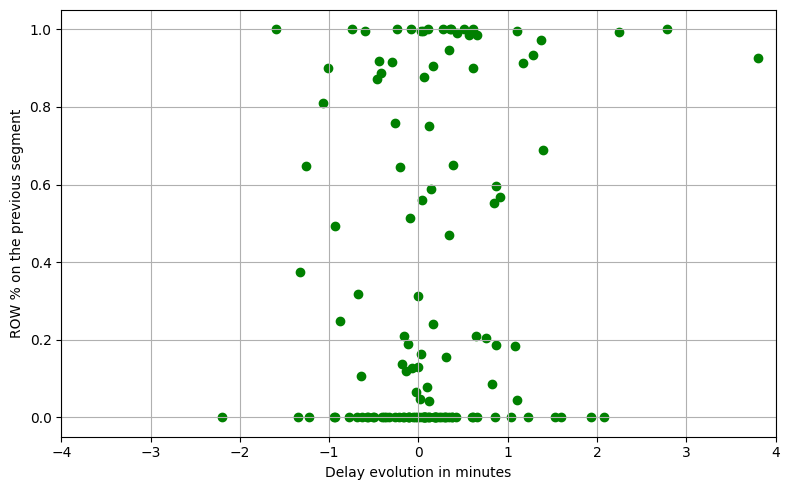

In [34]:
def corr(key):
    subset = performances_per_lines[key]

    path = f"C:/Users/chloe/Downloads/row_percentage_segment_line{key}.csv"
    line = subset['route_short_name'].unique()[0]
    dest = subset['stop_headsign'].unique()[0]
    ROW = pd.read_csv(path, sep=';')

    delays_by_stop = subset.groupby('stop_sequence_sched')['delays_evolution_minutes'].mean().reset_index()
    merged = pd.merge(ROW, delays_by_stop, left_on='stop_sequence_real', right_on='stop_sequence_sched')
    plt.scatter(merged['delays_evolution_minutes'], merged['percentage'],  color='green')

    
plt.figure(figsize=(8, 5))
plt.xlim(-4,4)
    
for key in performances_per_lines.keys():  
    corr(key)
    
plt.ylabel('ROW % on the previous segment')
plt.xlabel('Delay evolution in minutes')
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
df.columns

Index(['Unnamed: 0', 'trip_id', 'start_date', 'schedule_relationship',
       'stop_sequence_real', 'stop_id', 'arrival_time_real', 'arrival_delay',
       'departure_time_real', 'departure_delay', 'route_short_name',
       'service_id', 'arrival_time_sched', 'departure_time_sched',
       'stop_sequence_sched', 'stop_headsign', 'pickup_type', 'drop_off_type',
       'shape_dist_traveled', 'timepoint', 'pickup_booking_rule_id',
       'drop_off_booking_rule_id', 'stop_name', 'stop_lat', 'stop_lon',
       'location_type', 'parent_station', 'platform_code', 'file',
       'arrival_delay_minutes', 'dwell_time', 'delays_evolution_minutes',
       'dwell_time_secs', 'peak_hour'],
      dtype='object')

In [29]:
df_trips = df.groupby('trip_id').agg(
    departure_time_sched=pd.NamedAgg(column="departure_time_sched", aggfunc="min"),
    mean_dwell_time = pd.NamedAgg(column="dwell_time", aggfunc="mean"),
    arrival_delay_minutes = pd.NamedAgg(column="arrival_delay_minutes", aggfunc="mean"),
    max_arrival_delay = pd.NamedAgg(column="arrival_delay_minutes", aggfunc="max"))

In [30]:
df_original = df.copy()
df = df_trips

Text(0, 0.5, 'Arrival delay in minutes')

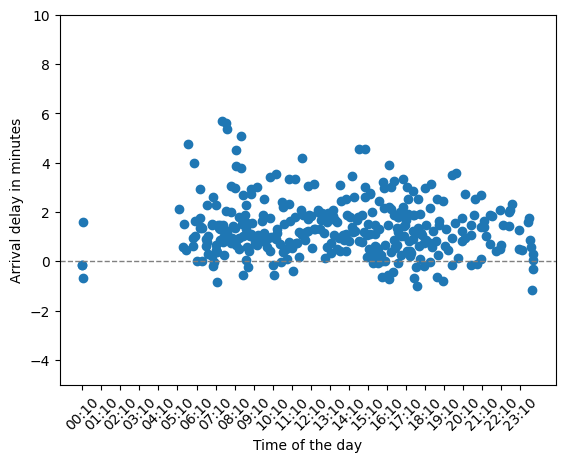

In [32]:
from datetime import datetime, timedelta

def parse_time_with_24(time_str):
    if time_str.startswith("24"):
        dt = datetime.strptime(time_str.replace("24", "00", 1), "%H:%M:%S")
        return dt
    else:
        return datetime.strptime(time_str, "%H:%M:%S")
df['start_hour'] = df['departure_time_sched'].apply(parse_time_with_24)

#df['start_hour'] = pd.to_datetime(df['start_hour'])
plt.scatter(df['start_hour'],df['arrival_delay_minutes'])
# Format x-axis: ticks every 30 minutes
locator = pd.date_range(start=df['start_hour'].min(),
                        end=df['start_hour'].max(),
                        freq='1h')

plt.xticks(locator, [ts.strftime('%H:%M') for ts in locator], rotation=45)
plt.ylim(-5,10)

# Optional: horizontal line (e.g., baseline at y=0)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Time of the day")
plt.ylabel("Arrival delay in minutes")
df = df_original.copy()